# Milestone 1

### Project idea

We want to create an interactive visualization with a map of France and its regions. When hovering over/clicking on a region, one can for example see the wine types grown in that region, their average ratings and typical words used to describe them. 

### Ideas for visualisation

Just wanted to write down some thoughts I had on how this could be presented: 

As many of the current visualizations that exist is basically google maps with locations on them, it could be cool to create a clean map (just the borders and names of the provinces). Then add different icons that signify the different varieties (a symbol of some kind, maybe their coat of arms). Then you can click on a province, get that province enlarged and see the different wineries, some information about them (maybe). 

Would also be cool to show some statistics of some kind for that province and their wines potentially. 



### Dataset description

The data was scraped from WineEnthusiast on November 22nd, 2017. The dataset can be found here: https://www.kaggle.com/zynicide/wine-reviews.

| Column name | Description |
| --- | --- |
| country | The country that the wine is from. |
| description | A few sentences from a sommelier describing the wine's taste, smell, look, feel, etc. | 
| designation | The vineyard within the winery where the grapes that made the wine are from. | 
| points | The number of points WineEnthusiast rated the wine on a scale of 1-100 (though they say they only post reviews for wines that score >=80). | 
| price | The cost for a bottle of the wine. (Currency?) | 
| province | The province or state that the wine is from. |
| region_1 | The wine growing area in a province or state. | 
| region_2 | Sometimes there are more specific regions specified within a wine growing area. |
| taster_name | Name of the taster. |
| taster_twitter_handle | Twitter name of the taster. |
| title | The title of the wine. | 
| variety | The type of grapes used to make the wine. |
| winery | The winery that made the wine |


## Data Cleaning

In [204]:
# Import packages that are used
import pandas as pd
import numpy as np
import re 
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# To ensure that axis-texts in plots are not cut off
plt.tight_layout()

<Figure size 1440x720 with 0 Axes>

In [205]:
df = pd.read_csv('Data/winemag-data-130k-v2.csv', sep = ',')
france = df[df.country.str.contains('France', na=False)]
france.head(3)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
7,7,France,This dry and restrained wine offers spice in p...,NaN,87,24.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Trimbach 2012 Gewurztraminer (Alsace),Gewürztraminer,Trimbach
9,9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam
11,11,France,"This is a dry wine, very spicy, with a tight, ...",NaN,87,30.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Leon Beyer 2012 Gewurztraminer (Alsace),Gewürztraminer,Leon Beyer


In [206]:
france.isnull().sum()

Unnamed: 0                   0
country                      0
description                  0
designation               7563
points                       0
price                     4317
province                     0
region_1                    76
region_2                 22093
taster_name                265
taster_twitter_handle      265
title                        0
variety                      0
winery                       0
dtype: int64

We are not interested in the columns: 'Unnamed: 0' (it has no meaning), country (we know which country it is), region_2 (it has no values), taster_name & taster_twitter_handle (it's not important who wrote the review).

We extract the year that the wine was produced, as a new column, by applying a regular expression on the title.

There are also a lot of missing values for designation and price, but for now we will keep these if they turn out to be of interest later on. Since there are 21099 rows in the dataset, it can be smart to stay clear of visualizing data about designation and price as about 30% and 20% of the data is missing respectively. 

In [207]:
# Drop unnecessary columns
wines = france.drop(['Unnamed: 0', 'country', 'region_2', 'taster_name','taster_twitter_handle'], axis=1)\
    .rename(columns={'region_1':'region'}).reset_index(drop = True)

# Extract year from title
wines['year'] = wines['title'].str.extract('(\d{4})')
wines.head(3)

,description,designation,points,price,province,region,title,variety,winery,year
0,This dry and restrained wine offers spice in p...,NaN,87,24.0,Alsace,Alsace,Trimbach 2012 Gewurztraminer (Alsace),Gewürztraminer,Trimbach,2012
1,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam,2012
2,"This is a dry wine, very spicy, with a tight, ...",NaN,87,30.0,Alsace,Alsace,Leon Beyer 2012 Gewurztraminer (Alsace),Gewürztraminer,Leon Beyer,2012


### What should we focus on in the data? 

#### Variety 
Exploration of the different varities

In [208]:
varieties = wines.variety.value_counts()
varieties

Bordeaux-style Red Blend    4725
Chardonnay                  2808
Pinot Noir                  1966
Rosé                        1923
Champagne Blend             1243
                            ... 
Malbec-Cabernet Franc          1
Edelzwicker                    1
Cabernet                       1
Roussanne-Marsanne             1
Chardonnay-Pinot Gris          1
Name: variety, Length: 148, dtype: int64

There are 148 different varieties in total. Might be smart to focus on the ones that occur more in the dataset, and 148 is also a lot to visualize. Might be a good idea to have a treshhold of minimum 30 occurences. That will include 35 varieties.  

In [209]:
# Create dataset with only these varietes. 
condition = varieties > 30
wanted_varieties = varieties[condition]

wines_lim = wines.loc[wines.variety.isin(wanted_varieties.index)]

In [210]:
wines_lim.head(3)

,description,designation,points,price,province,region,title,variety,winery,year
0,This dry and restrained wine offers spice in p...,NaN,87,24.0,Alsace,Alsace,Trimbach 2012 Gewurztraminer (Alsace),Gewürztraminer,Trimbach,2012
1,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam,2012
2,"This is a dry wine, very spicy, with a tight, ...",NaN,87,30.0,Alsace,Alsace,Leon Beyer 2012 Gewurztraminer (Alsace),Gewürztraminer,Leon Beyer,2012


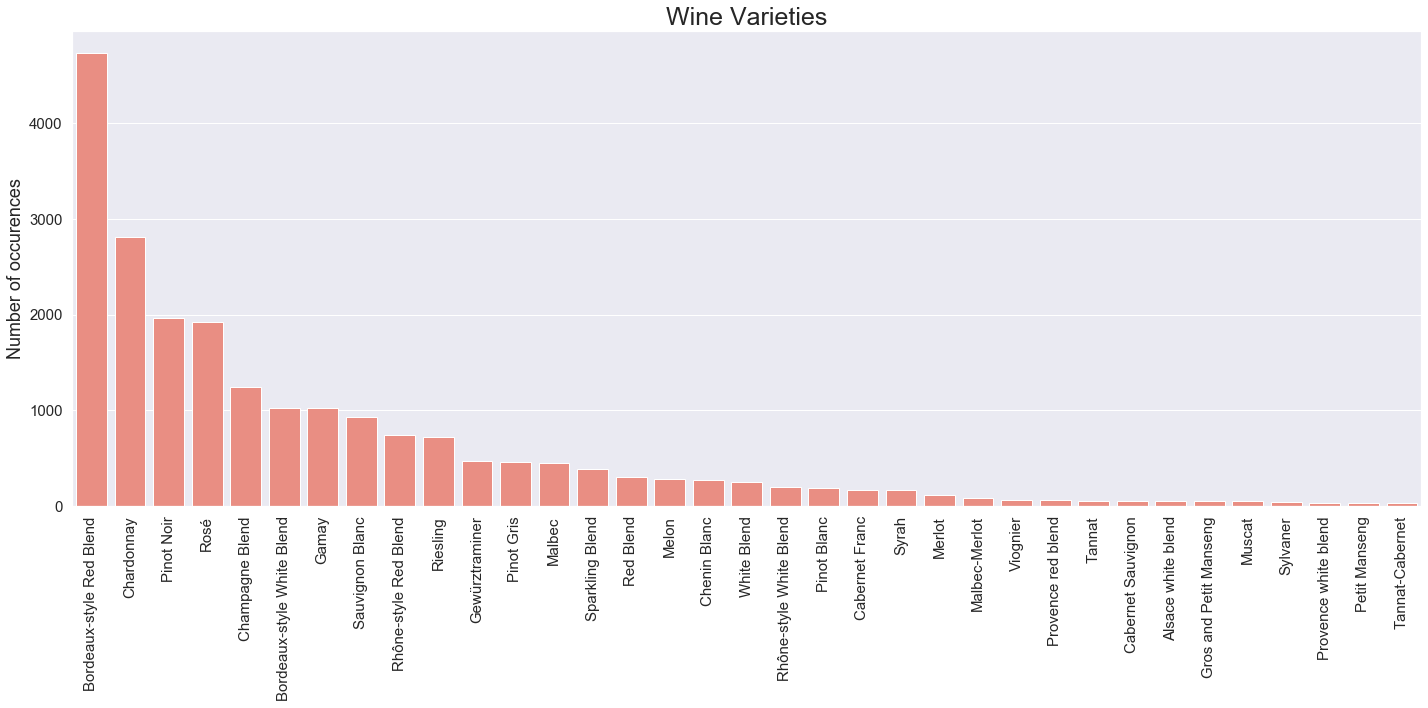

In [211]:
sns.set(rc={'figure.figsize':(20,10)})
s = sns.barplot(x = wanted_varieties.index, y = wanted_varieties.values, color = 'salmon')
s.set_xticklabels(labels = wanted_varieties.index, rotation=90) # rotate text on x-axis to avoid overlap
s.set_title('Wine Varieties', fontsize = 25)
s.set_ylabel('Number of occurences', fontsize = 18)

s.tick_params(labelsize=15)

plt.tight_layout()
plt.savefig('Plots/varieties_vertical.pdf', format='pdf')

#### Winery
Exploration of the different wineries

In [212]:
wineries = wines.winery.value_counts()
wineries

Louis Latour                       199
Georges Duboeuf                    196
Albert Bichot                      117
Jean-Luc and Paul Aegerter         113
Chanson Père et Fils               109
                                  ... 
Château Pavillon de Boyrein          1
Château Jeanrousse                   1
Château La Bastienne                 1
Domaine Gilles Chollet               1
Château Lacaussade-Saint-Martin      1
Name: winery, Length: 3864, dtype: int64

In [213]:
# We give the same treshhold as for varieties, that is 30
condition = wineries > 30
wanted_wineries = wineries[condition]

wines_lim = wines_lim.loc[wines_lim.winery.isin(wanted_wineries.index)].reset_index(drop = True)
wines_lim.head(3)

,description,designation,points,price,province,region,title,variety,winery,year
0,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam,2012
1,"This is a festive wine, with soft, ripe fruit ...",Nouveau,86,9.0,Beaujolais,Beaujolais,Henry Fessy 2012 Nouveau (Beaujolais),Gamay,Henry Fessy,2012
2,"Soft and fruity, this is a generous, ripe wine...",Eté Indien,86,14.0,Beaujolais,Brouilly,Vignerons de Bel Air 2011 Eté Indien (Brouilly),Gamay,Vignerons de Bel Air,2011


Have now reduced the dataset from 21099 to 6186 rows, which is also the amount after limiting the varieties. This means that no data is lost after removing the wineries with less than 30 occurences in the *france_lim* dataset. 

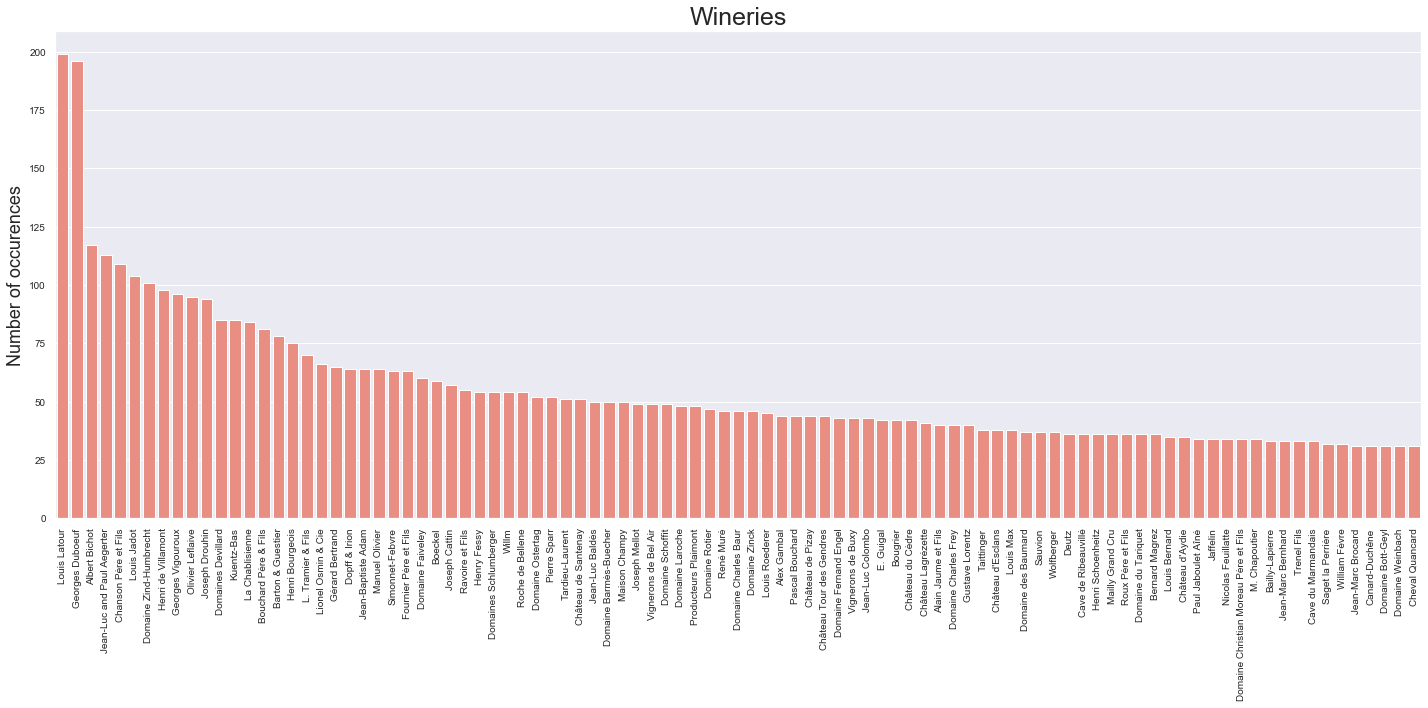

In [214]:
sns.set(rc={'figure.figsize':(20,10)})
s = sns.barplot(x = wanted_wineries.index, y = wanted_wineries.values, color = 'salmon')
s.set_xticklabels(labels = wanted_wineries.index, rotation=90) # rotate text on x-axis to avoid overlap
s.set_title('Wineries', fontsize = 25)
s.set_ylabel('Number of occurences', fontsize = 18)
s.tick_params(labelsize=10)

plt.tight_layout()
plt.savefig('Plots/wineries_vertical.pdf', format='pdf')

#### Price & Designation

In [215]:
wines_lim.price.value_counts(dropna = False)

NaN      714
20.0     221
25.0     180
15.0     174
30.0     158
        ... 
166.0      1
455.0      1
111.0      1
226.0      1
359.0      1
Name: price, Length: 255, dtype: int64

Now, 14% of the prices are missing. It should not be a problem to include the prices at this rate, but it may depend on the choice of visualization. 

In [216]:
wines_lim.designation.value_counts(dropna = False)

NaN                               975
Vieilles Vignes                    93
Réserve                            66
Brut Rosé                          58
Collection                         54
                                 ... 
Le Corton                           1
Sous la Roche                       1
Vendanges Manuelles Collection      1
Vieilles Vignes Réserve             1
Referts Premier Cru                 1
Name: designation, Length: 1585, dtype: int64

About 19% of the designation is now missing. This is also something to consider when choosing a visualization. 

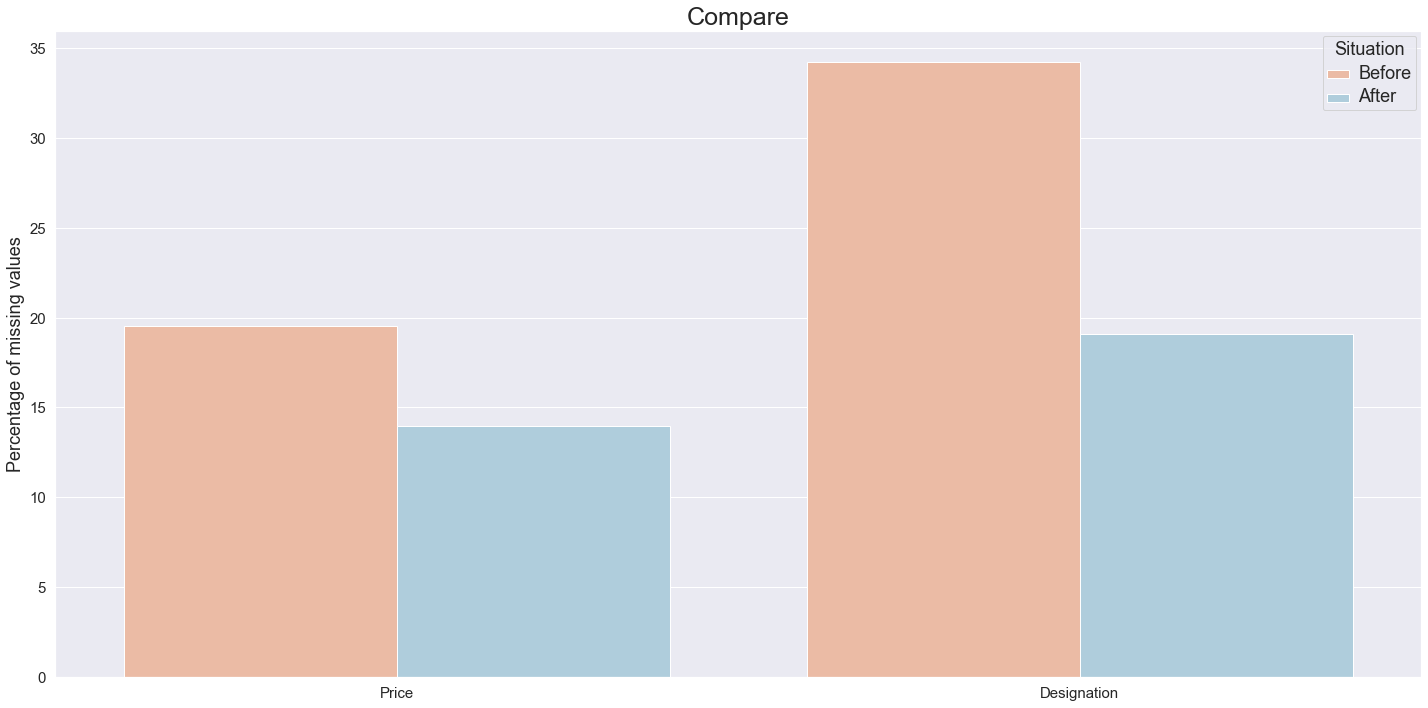

In [217]:
# Comparison of missing values before and now

price_before = (france.price.isnull().sum() / len(france)) * 100
price_after = (wines_lim.price.isnull().sum() / len(wines_lim)) * 100

designation_before = (france.designation.isnull().sum() / len(france)) * 100
designation_after = (wines_lim.designation.isnull().sum() / len(wines_lim)) * 100

data = {'Type':['Price', 'Price', 'Designation', 'Designation'], 'values':[price_before, price_after, designation_before, designation_after], 'Situation': ['Before', 'After', 'Before', 'After']} 

compare_values = pd.DataFrame(data)
compare_values

# Plotting data
sns.set(rc={'figure.figsize':(20,10)})
s = sns.barplot(x = 'Type', y = 'values', hue = 'Situation', palette = 'RdBu', data = compare_values)
plt.setp(s.get_legend().get_texts(), fontsize='18')
plt.setp(s.get_legend().get_title(), fontsize='18')

s.set_title('Compare', fontsize = 25)
s.set_ylabel('Percentage of missing values', fontsize = 18)
s.set_xlabel('', fontsize = 18)
s.tick_params(labelsize=15)

plt.tight_layout()
plt.savefig('Plots/compare.pdf', format='pdf')

#### Province

In [218]:
wines_lim.province.value_counts()

Burgundy                1968
Alsace                  1189
Southwest France         434
Beaujolais               374
Loire Valley             312
Rhône Valley             249
Champagne                220
Provence                 118
France Other              96
Bordeaux                  79
Languedoc-Roussillon      72
Name: province, dtype: int64

All of the provinces are still represented in the dataset after cleaning of the original dataset. We have not lost any representation of areas. 

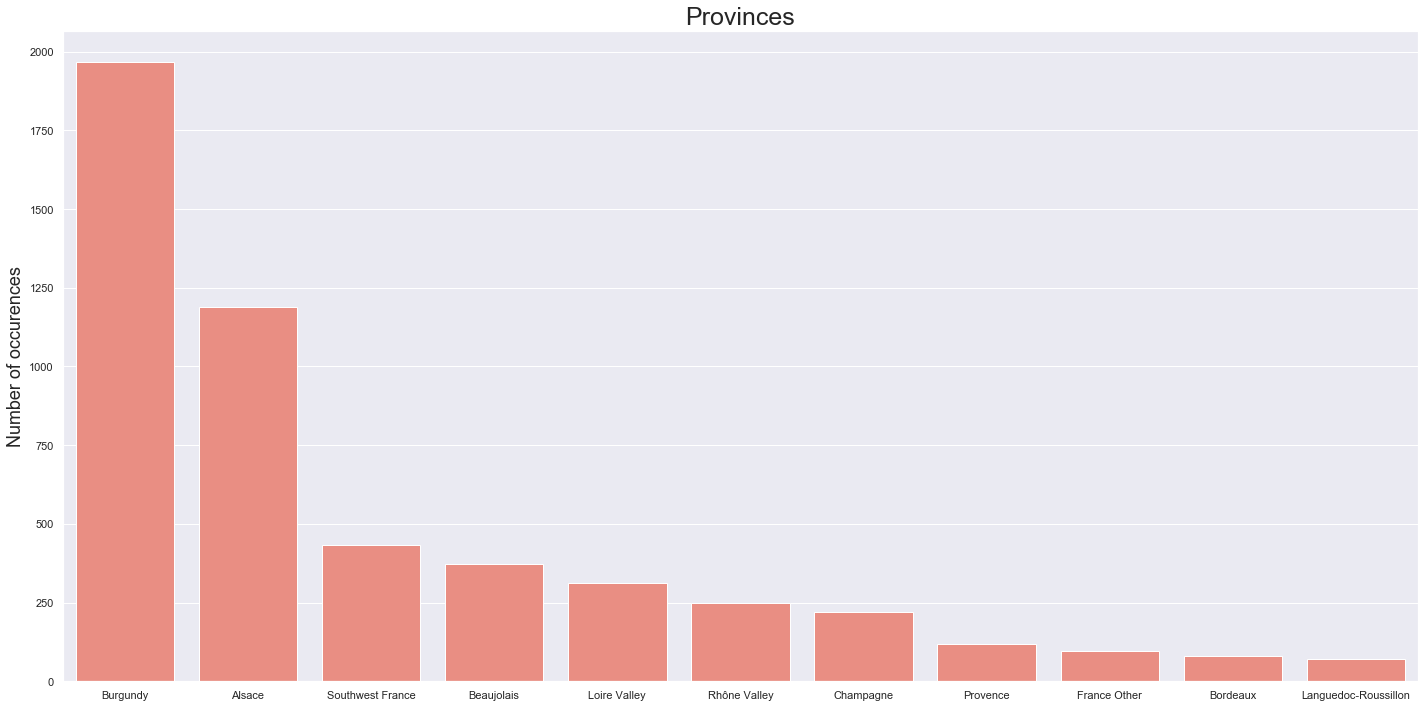

In [219]:
provinces = wines_lim.province.value_counts()

sns.set(rc={'figure.figsize':(20,10)})
s = sns.barplot(x = provinces.index, y = provinces.values, color = 'salmon')
s.set_title('Provinces', fontsize = 25)
s.set_ylabel('Number of occurences', fontsize = 18)

plt.tight_layout()
plt.savefig('Plots/provinces.pdf', format='pdf')

## Data Exploration

Group the dataset to get the average price and points for each type of variety in every region & province. Show also the amount of wines entailed in the calculation.

In [220]:
grouped = wines_lim.groupby(['province', 'region', 'variety'])\
    .agg({'price':'mean', 'points':'mean', 'title':'count'}).reset_index()
grouped

,province,region,variety,price,points,title
0,Alsace,Alsace,Alsace white blend,18.200000,88.590909,22
1,Alsace,Alsace,Chardonnay,22.666667,90.666667,3
2,Alsace,Alsace,Gewürztraminer,38.526087,90.271605,243
3,Alsace,Alsace,Muscat,37.045455,90.916667,24
4,Alsace,Alsace,Pinot Blanc,18.084507,87.431818,88
...,...,...,...,...,...,...
355,Southwest France,Vin de Pays du Comté Tolosan,Malbec,NaN,86.000000,2
356,Southwest France,Vin de Pays du Comté Tolosan,Red Blend,9.000000,86.000000,1
357,Southwest France,Vin de Pays du Comté Tolosan,Rosé,NaN,85.000000,1
358,Southwest France,Vin de Pays du Lot,Malbec,12.000000,84.000000,1


Group the dataset by province and region and retrieve all of the of varieties grown in each grouping.

In [221]:
provinces = wines_lim.groupby(['province', 'region']).agg({'variety':'unique'}).reset_index()
provinces

,province,region,variety
0,Alsace,Alsace,"[Pinot Gris, Riesling, Gewürztraminer, White B..."
1,Alsace,Crémant d'Alsace,"[Sparkling Blend, Pinot Noir, Chardonnay, Pino..."
2,Beaujolais,Beaujolais,[Gamay]
3,Beaujolais,Beaujolais Blanc,[Chardonnay]
4,Beaujolais,Beaujolais Rosé,"[Gamay, Rosé]"
...,...,...,...
214,Southwest France,Pacherenc du Vic Bilh,"[Gros and Petit Manseng, Petit Manseng]"
215,Southwest France,Saint-Mont,"[Red Blend, White Blend, Tannat]"
216,Southwest France,Vin de Pays des Côtes de Gascogne,"[White Blend, Sauvignon Blanc, Chardonnay, Tan..."
217,Southwest France,Vin de Pays du Comté Tolosan,"[Malbec, Rosé, Red Blend]"


Sort wines according to points and price.

In [222]:
sortedPointsPrice = wines_lim[['title', 'variety', 'province', 'region', 'points', 'price']].sort_values(by=['points', 'price'], ascending=(False, True))
sortedPointsPrice

,title,variety,province,region,points,price
3469,Louis Roederer 2008 Cristal Vintage Brut (Cha...,Champagne Blend,Champagne,Champagne,100,250.0
1943,Louis Jadot 2005 Charmes-Chambertin,Pinot Noir,Burgundy,Charmes-Chambertin,98,134.0
1944,Louis Jadot 2005 Clos de la Roche,Pinot Noir,Burgundy,Clos de la Roche,98,138.0
3907,M. Chapoutier 1999 Le Méal Ermitage (Hermitage),Rhône-style Red Blend,Rhône Valley,Hermitage,98,150.0
1074,Louis Jadot 2014 Bâtard-Montrachet,Chardonnay,Burgundy,Bâtard-Montrachet,98,367.0
...,...,...,...,...,...,...
889,Bougrier 2013 V Douce France (Vouvray),Chenin Blanc,Loire Valley,Vouvray,81,14.0
725,Georges Duboeuf 2001 Vin de Pays de l'Ardeche ...,Viognier,France Other,France,80,10.0
1391,Bougrier 2015 Gamay-Grolleau (Rosé d'Anjou),Rosé,Loire Valley,Rosé d'Anjou,80,11.0
4463,Cave de Ribeauvillé NV Giersberger Brut Sparkl...,Sparkling Blend,Alsace,Crémant d'Alsace,80,14.0


Calculate best wine quality for money.

In [223]:
bestValue = wines_lim[['title', 'variety', 'province', 'region', 'points', 'price']]
bestValue['points/price'] = wines_lim['points'] / wines_lim['price']
bestValue = bestValue.sort_values(by=['points/price'], ascending=False)
bestValue

/anaconda3/envs/ada/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,title,variety,province,region,points,price,points/price
4596,Producteurs Plaimont 2013 Terres d'Artagnan Cu...,White Blend,Southwest France,Côtes de Gascogne,86,7.0,12.285714
2309,Barton & Guestier 2013 Réserve Sauvignon Blanc...,Sauvignon Blanc,Southwest France,Côtes de Gascogne,85,7.0,12.142857
4359,Barton & Guestier 2010 Reserve Sauvignon Blanc...,Sauvignon Blanc,Southwest France,Côtes de Gascogne,86,8.0,10.750000
2307,Producteurs Plaimont 2013 Colombelle L'Origine...,Red Blend,Southwest France,Côtes de Gascogne,85,8.0,10.625000
836,Producteurs Plaimont 2007 Colombelle White Whi...,White Blend,Southwest France,Vin de Pays des Côtes de Gascogne,85,8.0,10.625000
...,...,...,...,...,...,...,...
5078,Lionel Osmin & Cie 2011 Pont du Diable Malbec ...,Malbec,France Other,Vin de France,89,NaN,NaN
5081,Château Tour des Gendres 2011 Moulin des Dames...,Bordeaux-style White Blend,Southwest France,Bergerac Sec,90,NaN,NaN
5088,Henri de Villamont 2014 Les Baudes Premier Cru...,Pinot Noir,Burgundy,Chambolle-Musigny,93,NaN,NaN
5090,René Muré 2011 Côte de Rouffach Pinot Noir (Al...,Pinot Noir,Alsace,Alsace,87,NaN,NaN


## More interesting plots

**Points distribution for the different provinces**

We use a violin plot to show how the points vary for each province in France and we order using the mean points of every province.

In [224]:
df = wines[['points','price', 'province']].sort_values(by='province')
grouped = df.groupby(['province']).agg({'price':'mean', 'points':'mean'}).reset_index()
sorted_index = grouped.sort_values(by='points')

<function matplotlib.pyplot.show(*args, **kw)>

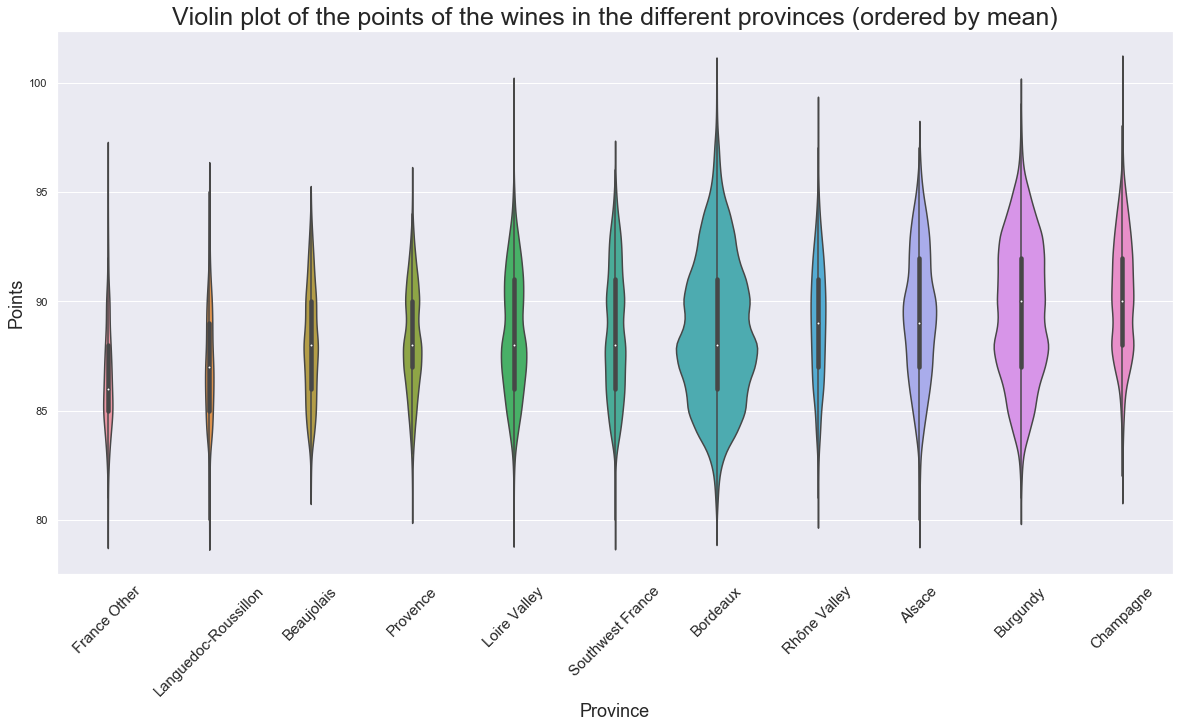

In [225]:
plt.figure(figsize=(20,10))
ax = sns.violinplot(x='province', y='points', data=df, scale='count', order=sorted_index.province)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=15)
ax.set_ylabel('Points', fontsize=18)
ax.set_xlabel('Province', fontsize=18)
plt.title('Violin plot of the points of the wines in the different provinces (ordered by mean)', fontsize=25)
plt.show

As we can see, the provinces are quite similar in their point ranges, which makes sense since plenty of different types of wines are grown in each province. However, when looking at the ordering, we can see that Champagne has the highest mean which is not surprising as champagne is an exclusive type of wine. 

**Price distribution for the different provinces**

Now we look at how the prices are distributed for the different provinces. Again the provinces are ordered by the mean and the width is adjusted to the number of observations. Observe that the y-axis is log scaled.

In [226]:
grouped = df.groupby(['province']).agg({'price':'mean', 'points':'mean'}).reset_index()
sorted_index = grouped.sort_values(by='price')

<function matplotlib.pyplot.show(*args, **kw)>

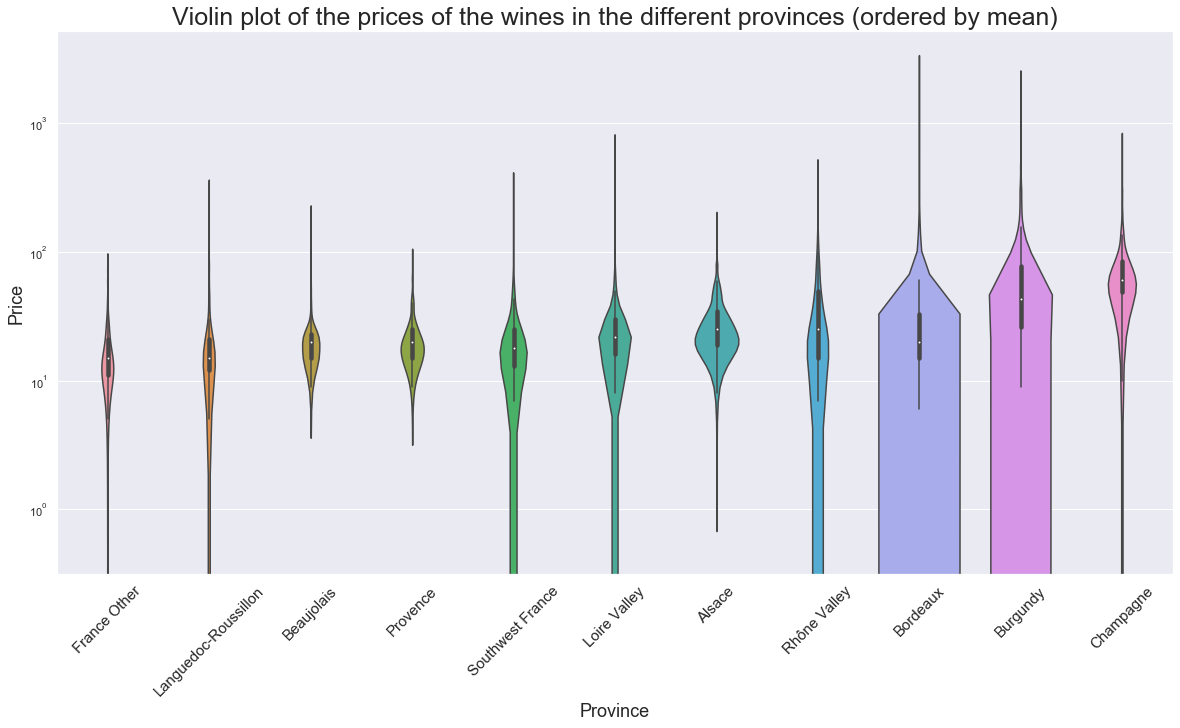

In [227]:
plt.figure(figsize=(20,10))
ax = sns.violinplot(x='province', y='price', data=df, scale='count', order=sorted_index.province)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=15)
ax.set(yscale="log")
ax.set_ylabel('Price', fontsize=18)
ax.set_xlabel('Province', fontsize=18)
plt.title('Violin plot of the prices of the wines in the different provinces (ordered by mean)', fontsize=25)
plt.show

Again Champagne has a higher mean than the rest, which again makes sense since exclusive wines are grown there. In this plot there is a bigger difference between the provinces.

**Points distribution for the different regions in Bordeaux**

Now we look at the largest producing province Bordeaux and how its regions differ. We should se a more varying plot here as smaller areas can differ a lot from each other. This is because the soil, climate, temperatures, etc. change depending on the area, creating different types of wines where some are of better quality and some are of worse quality.

In [228]:
data = wines[wines.province.str.contains('Bordeaux')]
df = data[['points','price','region']].sort_values(by='region')

grouped = df.groupby(['region']).agg({'price':'mean', 'points':'mean'}).reset_index()
sorted_index = grouped.sort_values(by='points')

<function matplotlib.pyplot.show(*args, **kw)>

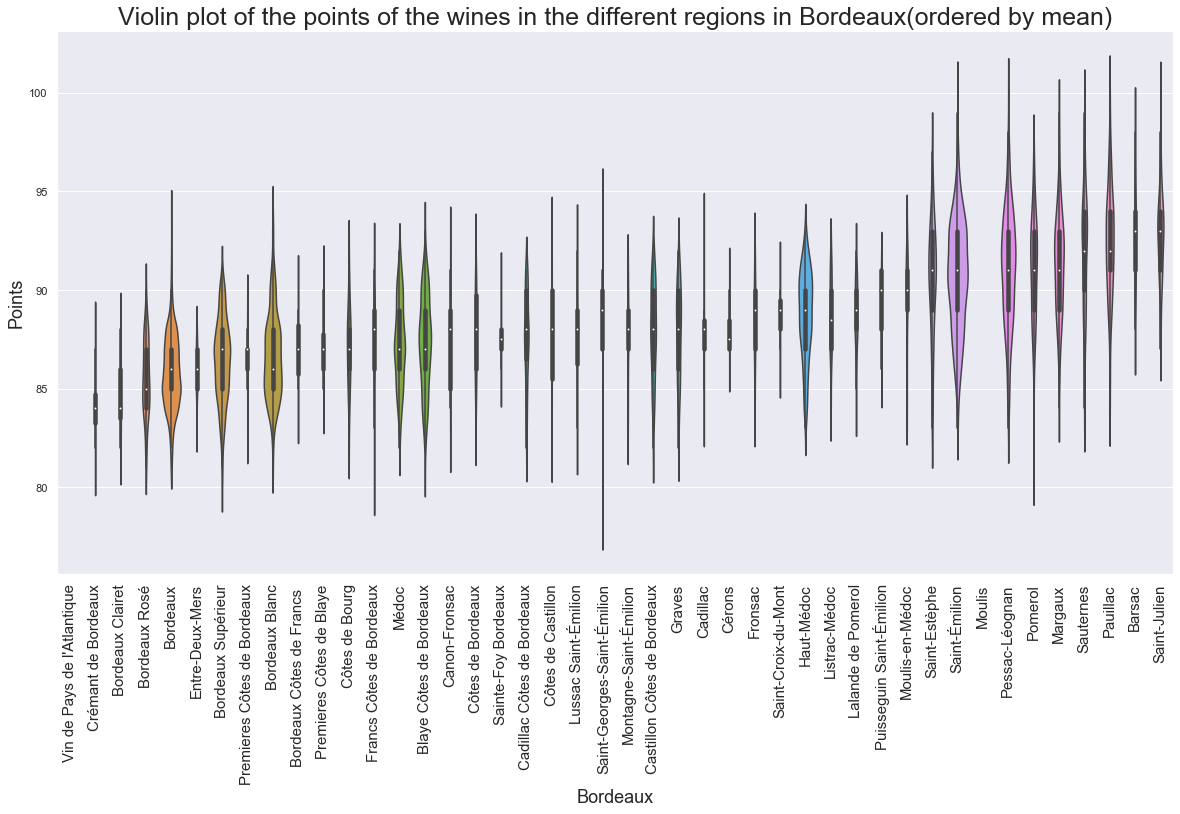

In [229]:
plt.figure(figsize=(20,10))
ax = sns.violinplot(x='region', y='points', data=df, scale='count', order=sorted_index.region)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=15)
ax.set_ylabel('Points', fontsize=18)
ax.set_xlabel('Bordeaux', fontsize=18)
plt.title('Violin plot of the points of the wines in the different regions in Bordeaux(ordered by mean)', fontsize=25)
plt.show

As we can see, this plot differs more than the ones above. 

**Observation**

One must remember that the wines in the dataset are only wines that have been rated 80/100 or higher. Therefore, they are all wines of good quality and will not vary much in points. The price is something that can vary more, but since we are missing values when it comes to the prices, this is not as trustworthy. 

### Comparison of Price vs. Points

As the prices may vary more, as there are missing values, it can be interesting to also take a look at the comparisons between prices and points. 

First we will look at the distribution with regards to Points and Price. 

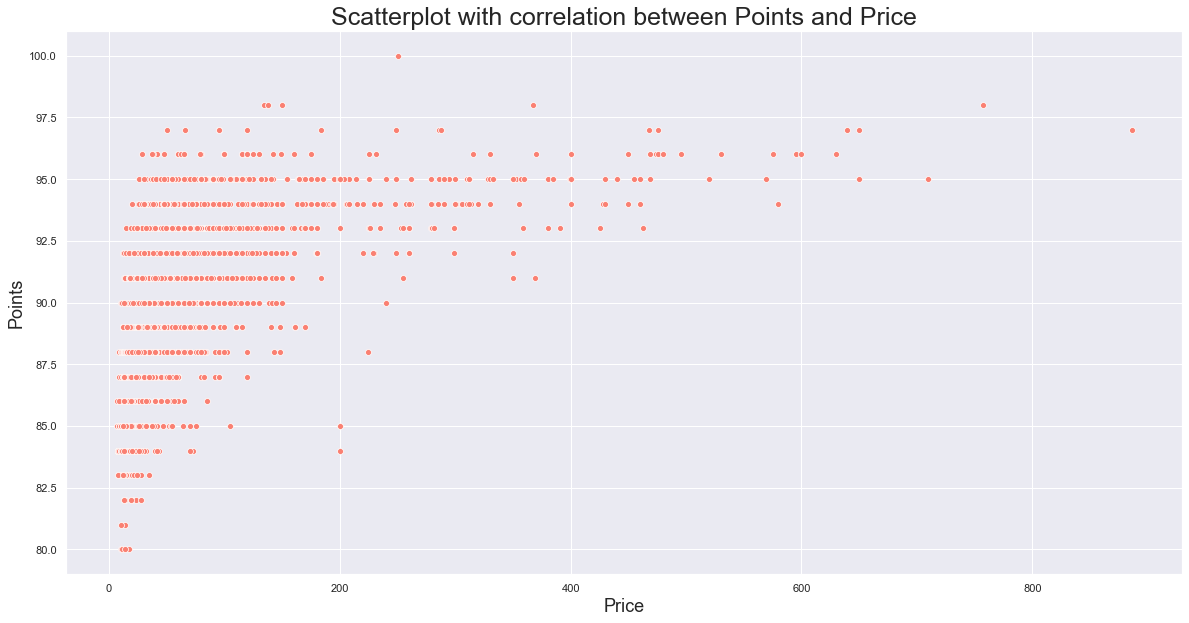

In [230]:
plt.figure(figsize=(20,10))
ax = sns.scatterplot(x='price', y='points', color = 'salmon', data=wines_lim)
#ax.set_xticklabels(wines_lim.year, rotation=90, fontsize=15)
ax.set_ylabel('Points', fontsize=18)
ax.set_xlabel('Price', fontsize=18)
plt.title('Scatterplot with correlation between Points and Price', fontsize=25)

plt.savefig('Plots/scatter_pvsp.pdf', format='pdf')
plt.show()

Here, we can see that there are a lot of wines that stays within a price of 0-200. There are also more bottles that are given a lot of points, then are given towards the 80-point mark. We can also see that if the wine is more expensive it get's on average the highest ratings.

#### Comparison of price and points by year

In [231]:
data = wines_lim.groupby('year').mean() 
data = {'value': data['price'].tolist() + data['points'].tolist(), 'Type': len(data)*['Price'] + len(data)*['Points'], 'year': data.index.tolist() * 2}
df = pd.DataFrame(data)
df = df.sort_values(by='year')

Take notice of the number of missing values for both price and year. We choose to remove the rows that contain empty values for year, as they are redundant. 

In [232]:
df.dropna(subset=['year'], inplace = True)

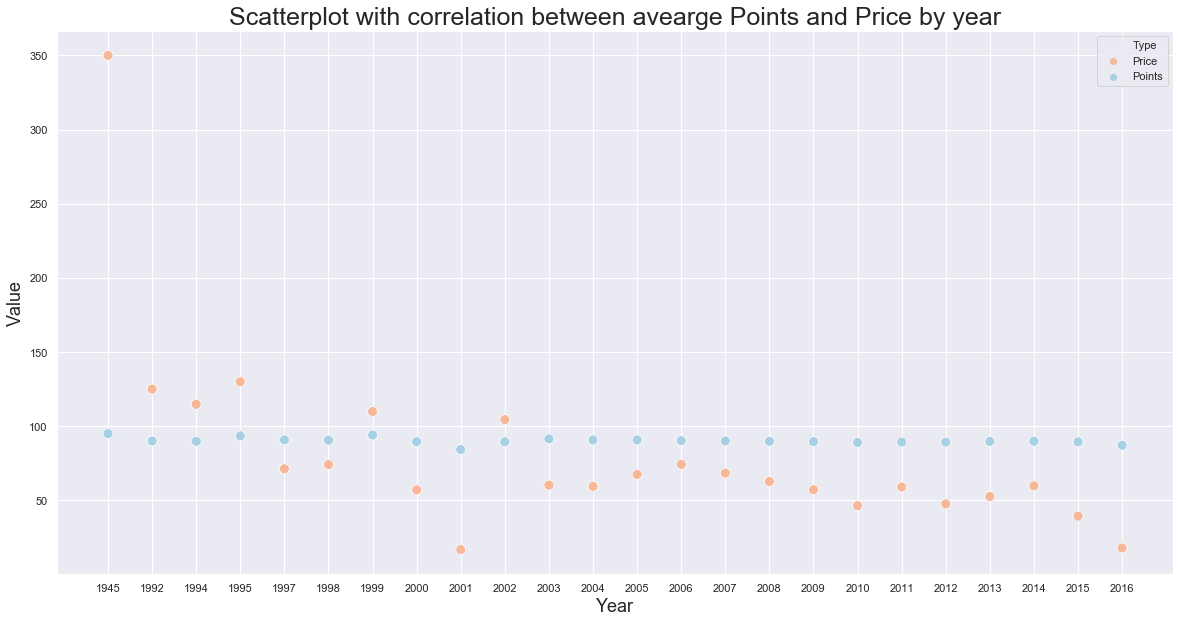

In [233]:
plt.figure(figsize=(20,10))
ax = sns.scatterplot(x='year', y='value', hue = 'Type', palette = 'RdBu', s = 100, data=df)
#ax.set_xticklabels(wines_lim.year, rotation=90, fontsize=15)
ax.set_ylabel('Value', fontsize=18)
ax.set_xlabel('Year', fontsize=18)
plt.title('Scatterplot with correlation between avearge Points and Price by year', fontsize=25)

plt.savefig('Plots/scatter_avgPP.pdf', format='pdf')
plt.show()

We can see that the average points have stayed quite equal over the years. As the metric is only from 80-100, it is also hard to distinguish any big changes, but we can see that it stabilised a small amount from 2002-2016. As for the price it varies a little bit more. This might be due to the economic situatuon or that production levels have changed. 

*Sidenote: might remove 1945 from the dataset as there is a big gap with missing years.*

### Conclusion
For our use the scatterplot with average price and points over the years could be used to show the same wines, but from different years to compare if there is a year that had a better production. The correlation between price and points is also interesting to maybe show wines that has the same price, but different points so the user can compare. 